In [46]:
!pip install seaborn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [48]:
df_train = pd.read_csv('../datasets/insurance_train.csv')
df_test = pd.read_csv('../datasets/insurance_test.csv')
print(df_train.head())

   age     sex     bmi  children smoker     region      charges
0   26    male  27.060         0    yes  southeast  17043.34140
1   58    male  36.955         2    yes  northwest  47496.49445
2   20  female  24.420         0    yes  southeast  26125.67477
3   51  female  38.060         0    yes  southeast  44400.40640
4   62  female  25.000         0     no  southwest  13451.12200


<h1 style="text-align:center">1. Подготовка данных</h1>
<br> 1. Проверить наличие пропусков и выбросов


In [49]:
print(df_train.dtypes)
print(df_test.dtypes)
print(df_train.isna().sum())
df_test.isna().sum()

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Замечаем, что пропусков нет <br>

{'southwest', 'northwest', 'northeast', 'southeast'}
     age    sex     bmi  children  smoker      charges  southwest  northwest  \
0     26   True  27.060         0    True  17043.34140      False      False   
1     58   True  36.955         2    True  47496.49445      False       True   
2     20  False  24.420         0    True  26125.67477      False      False   
3     51  False  38.060         0    True  44400.40640      False      False   
4     62  False  25.000         0   False  13451.12200       True      False   
..   ...    ...     ...       ...     ...          ...        ...        ...   
333   25  False  22.515         1   False   3594.17085      False       True   
334   18   True  53.130         0   False   1163.46270      False      False   
335   64   True  37.905         0   False  14210.53595      False       True   
336   54  False  47.410         0    True  63770.42801      False      False   
337   28  False  25.800         0   False   3161.45400       True  

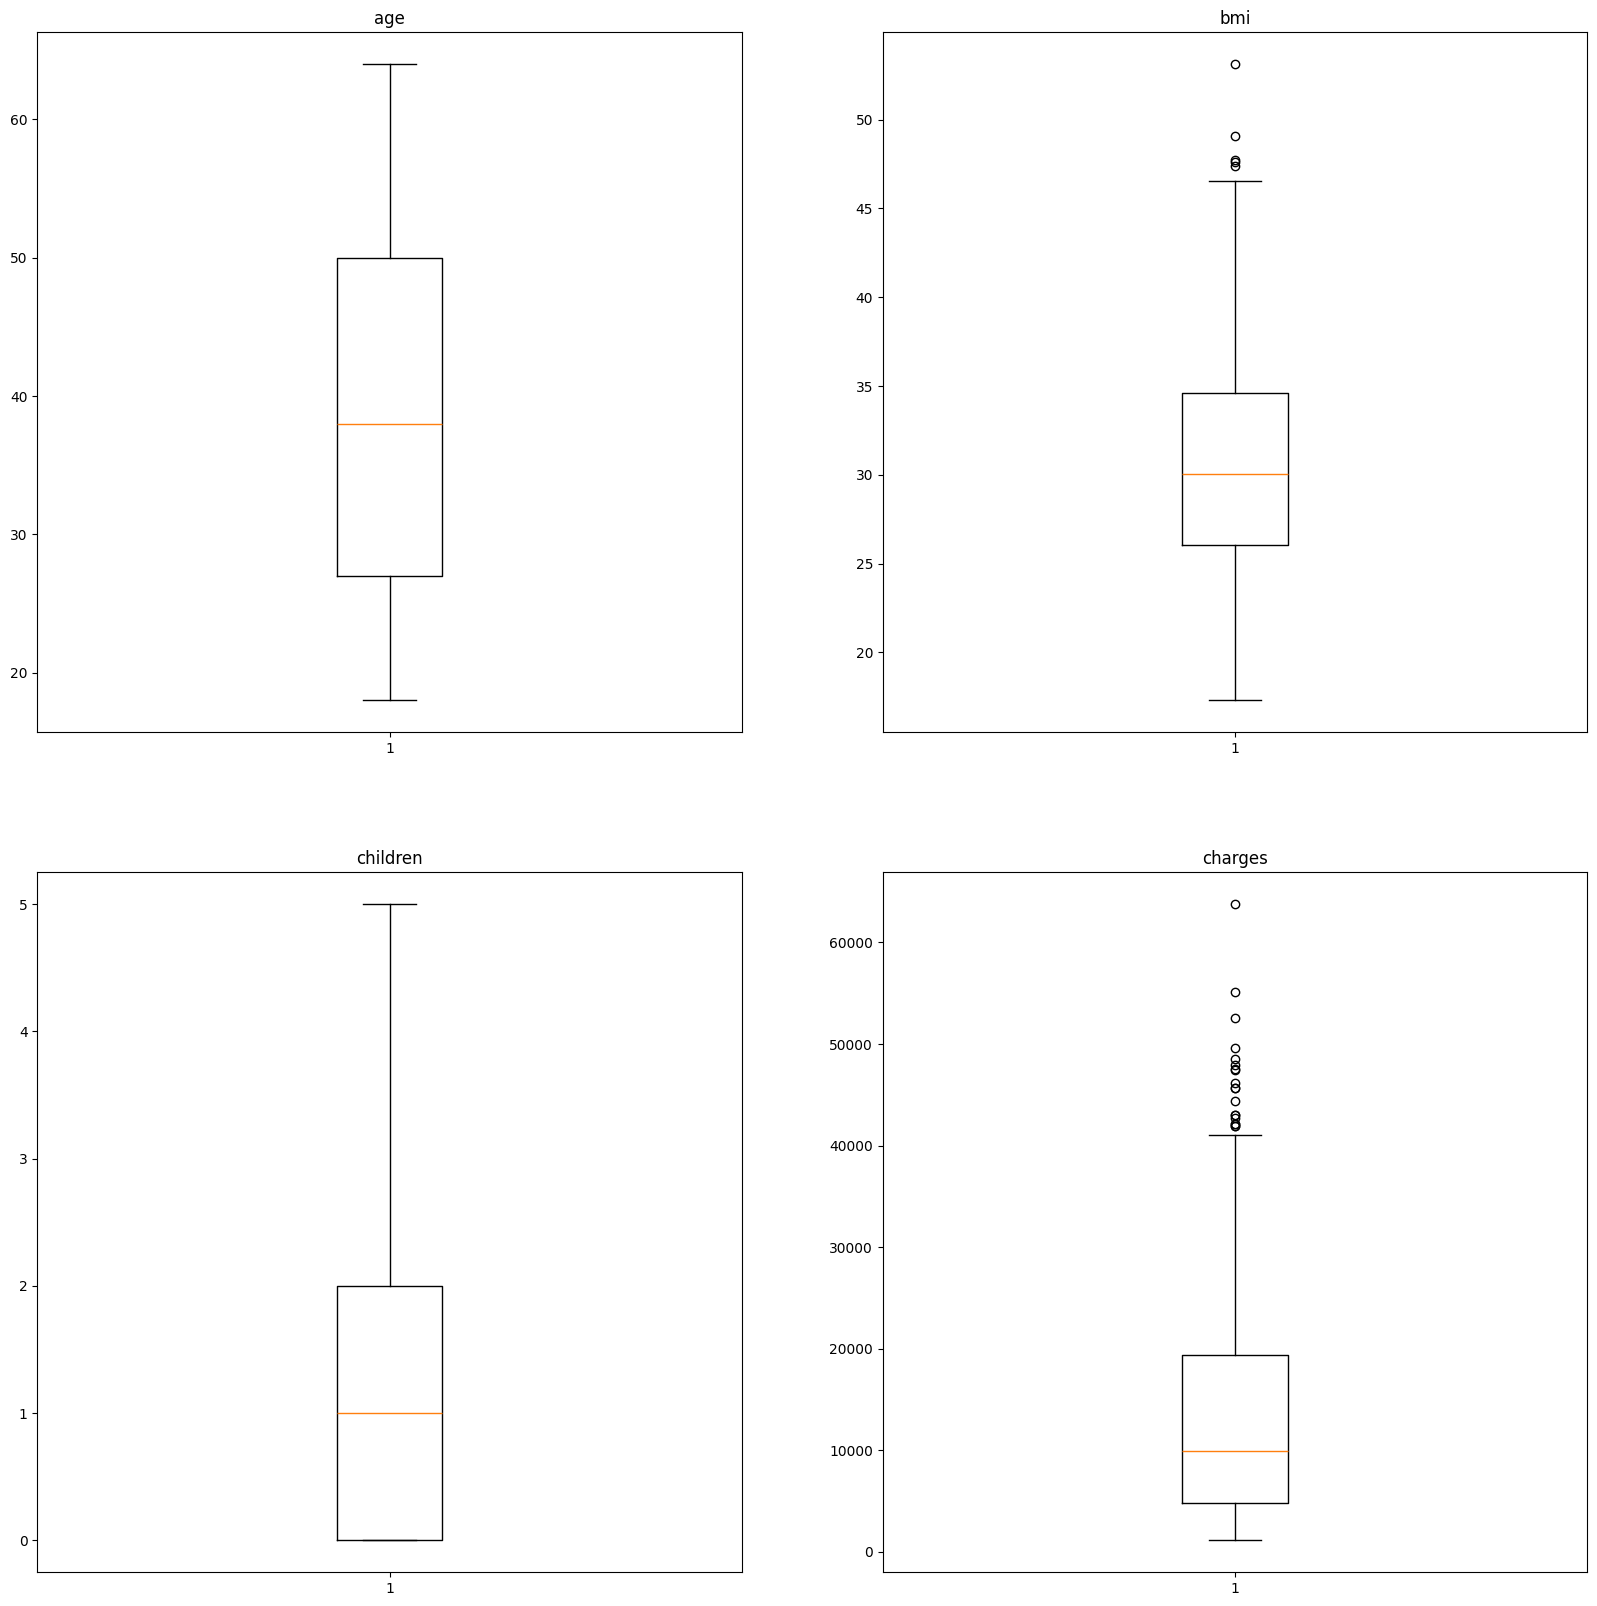

In [50]:
df_train["sex"] = df_train["sex"] == "male"
df_test["sex"] = (df_test["sex"] == "male").astype(int)
# print(df_train["sex"])
df_train["smoker"] = df_train["smoker"] == "yes"
df_test["smoker"] = (df_test["smoker"] == "yes").astype(int)
regions = set(df_train["region"])
print(regions)

for region in regions:
    df_train[str(region)] = df_train["region"] == region
    df_test[str(region)] = (df_test["region"] == region).astype(int)
df_train = df_train.drop("region", axis=1)
df_test = df_test.drop("region", axis=1)
print(df_train)

rows = 2
cols = 2


fig, axs = plt.subplots(figsize=(20, 20), nrows=rows, ncols=cols)
axs = axs.flatten()
numeric_cols = df_train.select_dtypes(include=['int64', 'float64']).columns

for i, col in enumerate(numeric_cols):
    axs[i].boxplot(df_train[col].dropna())
    axs[i].set_title(col)

for j in range(i + 1, rows * cols):
    fig.delaxes(axs[j])


print(df_train.dtypes)

In [51]:
df_train["smoker"] = df_train["smoker"].astype(int)
df_train["sex"] = df_train["sex"].astype(int)
for region in regions:
    df_train[str(region)] = df_train[str(region)].astype(int)

Нормализуем данные

In [52]:

Q1 = df_train[numeric_cols].quantile(0.25)
Q3 = df_train[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# print(lower_bound, upper_bound)

within_bounds = (df_train[numeric_cols] >= lower_bound) & (df_train[numeric_cols] <= upper_bound)
# print(within_bounds)

row_mask_keep = within_bounds.all(axis=1)
print(f'Outliers count in Data Frame: {len(df_train) - sum(row_mask_keep)}')
# print(row_mask_keep)

df_train = df_train[row_mask_keep].copy()
print(df_train.shape)

print(df_train.head())
print(df_train.dtypes)



Outliers count in Data Frame: 22
(316, 10)
   age  sex    bmi  children  smoker      charges  southwest  northwest  \
0   26    1  27.06         0       1  17043.34140          0          0   
2   20    0  24.42         0       1  26125.67477          0          0   
4   62    0  25.00         0       0  13451.12200          1          0   
5   34    1  32.80         1       0  14358.36437          1          0   
6   18    1  33.77         1       0   1725.55230          0          0   

   northeast  southeast  
0          0          1  
2          0          1  
4          0          0  
5          0          0  
6          0          1  
age            int64
sex            int64
bmi          float64
children       int64
smoker         int64
charges      float64
southwest      int64
northwest      int64
northeast      int64
southeast      int64
dtype: object


3. вычислить парные корреляции признаков

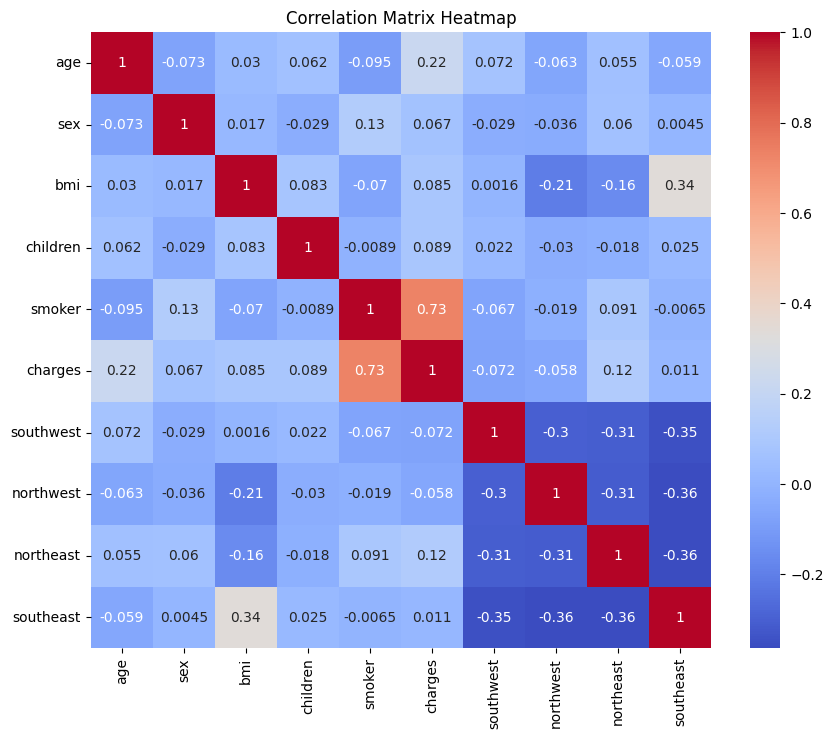

In [53]:
import seaborn as sns
cor_matrix = df_train.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(cor_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix Heatmap")
plt.show()



<h1 style="text-align:center">2. Многомерная линейная регрессия</h1>

1. аналитически (реализовать самому)

In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
coef_names = ["Intercept"]

X = df_train.copy()
X = X.drop("charges", axis=1)

coef_names += X.columns.to_list()
X_test = df_test.copy()
X_test = X_test.drop("charges", axis=1)

X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

print(X_test.shape)
print(X.shape)

y = df_train['charges']
y = y.to_numpy().reshape(-1, 1) 
y_test = df_test["charges"]
y_test = y_test.to_numpy().reshape(-1, 1)

(1000, 9)
(316, 9)


In [ ]:

X_b = np.hstack([np.ones((X.shape[0], 1)), X])

# β = (X^T X)^(-1) X^T y
XTX = X_b.T @ X_b          # X^T X
XTy = X_b.T @ y            # X^T y
beta = np.linalg.inv(XTX) @ XTy

beta_df = pd.DataFrame({
    "Feature": coef_names,
    "Coefficient": beta.flatten()
})

print(beta_df)

def predict(X, beta):
        X_b = np.hstack([np.ones((X.shape[0], 1)), X])
        return X_b @ beta

y_pred = predict(X_test, beta)
# print(y_pred)
MSE_analit = np.mean((y_test - y_pred) ** 2)
mean = np.mean(y_test)
R_2_analit = 1 - MSE_analit / np.var(y_test)
print(f'MSE = {MSE_analit}')
print(f'R_2 = {R_2_analit}')


     Feature   Coefficient
0  Intercept  12183.219129
1        age   2864.040201
2        sex   -115.792555
3        bmi   1349.870121
4   children    700.296947
5     smoker   7759.094387
6  southwest      0.000000
7  northwest    320.000000
8  northeast    576.000000
9  southeast    192.000000
[[14586.4202202 ]
 [13975.6449817 ]
 [ 7083.59309661]
 [ 5797.91376966]
 [ 9428.35266006]
 [ 7740.25126322]
 [ 5812.077208  ]
 [29710.03028989]
 [ 4151.78133712]
 [ 9432.10217905]
 [27982.49149526]
 [ 4451.81071886]
 [ 5944.64706764]
 [ 4398.93667106]
 [ 4410.34479357]
 [26413.24138292]
 [ 9453.91708449]
 [13865.32204126]
 [10550.20929162]
 [16716.61979249]
 [24962.50103575]
 [34193.76870887]
 [ 5098.6526267 ]
 [ 3075.93072043]
 [10369.70451999]
 [ 4845.79939525]
 [24045.68180802]
 [ 3734.12971831]
 [ 4004.37799202]
 [ 5673.96229639]
 [24609.06044143]
 [10828.57187251]
 [26549.87198669]
 [33589.35146555]
 [ 4560.18058261]
 [ 5059.05126556]
 [35107.61599642]
 [ 5366.3551793 ]
 [ 4740.73952898]
 

2. численно, с помощью методов градиентного спуска (реализовать самому)

In [56]:
class LinearRegressionGD:
    def __init__(self, learning_rate=0.01, n_iters=1000):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.theta = None

    def fit(self, X, y):
        m, n = X.shape
        
        X_b = np.hstack([np.ones((m, 1)), X])
        
        self.theta = np.zeros((n + 1, 1))
        y = y.reshape(-1, 1)

        for _ in range(self.n_iters):
           
            y_pred = X_b @ self.theta
            gradients = (1/m) * (X_b.T @ (y_pred - y))
            self.theta -= self.learning_rate * gradients

    def predict(self, X):
        X_b = np.hstack([np.ones((X.shape[0], 1)), X])
        return X_b @ self.theta

model = LinearRegressionGD(learning_rate=0.01, n_iters=100000)
model.fit(X, y)
# print(model.theta)

y_pred = model.predict(X_test)
MSE_grad = np.mean((y_test - y_pred) ** 2)
mean = np.mean(y_test)
R_2_grad = 1 - MSE_grad / np.var(y_test)
# print(y_pred)
print("Theta (веса):", model.theta.ravel())
print(f'MSE = {MSE_grad}')
print(f'R_2 = {R_2_grad}')

Theta (веса): [12183.2191294   2863.5106877   -118.42559122  1366.47215097
   701.49835791  7754.32101609  -344.55148808    25.82073498
   422.14979767  -102.88664421]
MSE = 37408894.388089456
R_2 = 0.7339701490491779


<h1 style="text-align:center">3. Добавление регуляризации</h2>

In [57]:
import numpy as np
import pandas as pd

lambda_ = 0.1

X_b = np.hstack([np.ones((X.shape[0], 1)), X])

XTX = X_b.T @ X_b
XTy = X_b.T @ y

I = np.eye(XTX.shape[0])
I[0, 0] = 0 

beta_ridge = np.linalg.inv(XTX + lambda_ * I) @ XTy

beta_df = pd.DataFrame({
    "Feature": list(coef_names),
    "Coefficient": beta_ridge.flatten()
})
print(beta_df)

def predict(X, beta):
    X_b = np.hstack([np.ones((X.shape[0], 1)), X])
    return X_b @ beta

y_pred = predict(X_test, beta_ridge)

MSE_analit_reg = np.mean((y_test - y_pred) ** 2)
R_2_analit_reg = 1 - MSE_analit_reg / np.var(y_test)
print(f"MSE = {MSE_analit_reg}, R^2 = {R_2_analit_reg}")


     Feature   Coefficient
0  Intercept  12183.219129
1        age   2862.392065
2        sex   -118.137689
3        bmi   1365.818996
4   children    701.375501
5     smoker   7751.673528
6  southwest   -344.529424
7  northwest     25.627245
8  northeast    422.187902
9  southeast   -102.762051
MSE = 37419811.952703275, R^2 = 0.733892509810316


In [58]:
class LinearRegressionGDReg:
    def __init__(self, learning_rate=0.01, n_iters=1000, lambda_=0.1):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.lambda_ = lambda_
        self.theta = None

    def fit(self, X, y):
        m, n = X.shape
        X_b = np.hstack([np.ones((m, 1)), X])
        y = y.reshape(-1, 1)

        self.theta = np.zeros((n + 1, 1))

        for _ in range(self.n_iters):
            y_pred = X_b @ self.theta
            gradients = (1/m) * (X_b.T @ (y_pred - y))
            
            # добавляем регуляризацию
            reg = (self.lambda_ / m) * self.theta
            reg[0] = 0
            
            self.theta -= self.learning_rate * (gradients + reg)

    def predict(self, X):
        X_b = np.hstack([np.ones((X.shape[0], 1)), X])
        return X_b @ self.theta


model_reg = LinearRegressionGDReg(learning_rate=0.01, n_iters=100000, lambda_=0.1)
model_reg.fit(X, y)
y_pred = model_reg.predict(X_test)
MSE_grad_reg = np.mean((y_test - y_pred) ** 2)
R_2_grad_reg = 1 - MSE_grad_reg / np.var(y_test)

print("Theta (веса):", model.theta.ravel())
print(f"MSE = {MSE_grad_reg}, R^2 = {R_2_grad_reg}")


Theta (веса): [12183.2191294   2863.5106877   -118.42559122  1366.47215097
   701.49835791  7754.32101609  -344.55148808    25.82073498
   422.14979767  -102.88664421]
MSE = 37419811.95270334, R^2 = 0.7338925098103154


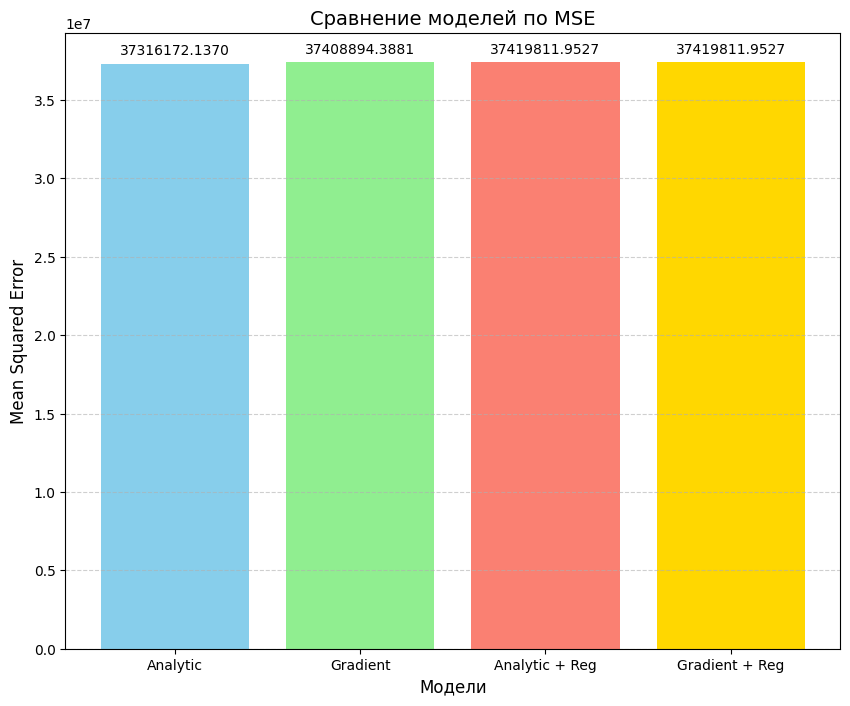

In [59]:

mse_values = [MSE_analit, MSE_grad, MSE_analit_reg, MSE_grad_reg]
model_names = ['Analytic', 'Gradient', 'Analytic + Reg', 'Gradient + Reg']

plt.figure(figsize=(10, 8))
bars = plt.bar(model_names, mse_values, color=['skyblue', 'lightgreen', 'salmon', 'gold'])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height * 1.01, f'{height:.4f}', 
             ha='center', va='bottom', fontsize=10)

plt.title('Сравнение моделей по MSE', fontsize=14)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.xlabel('Модели', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()
